# Asset Management Homework 1
### Aidan Cremins, Joe Morris, Peyton Lewis

## Assumptions:
<li>Transaction costs of index rebalancing are zero.</li>
<li>Rebalancing occurs on the first trading day at the beginnng of every quarter (January, April, July, October) as opposed to looking back at the previous quarter.</li>
<li>Reconstitution occurs on the first trading day at the beginning of the 4th quarter (October). Most companies are added or removed in August or September.</li>
<li>For any NaN values (missing values) in the 'trfd' column, we assume that the relevant ratio is one.</li>
<li>The data range is inclusive of the start and end dates (12/31/2011 and 12/31/2021).</li>
<li>Since we do not need to replicate the exact value of the Dow Jones Industrial Average, but just the returns, we assume the divisor is zero for all days in the data set.</li>


### Necessary Imports

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import statsmodels.api as sm
import warnings 
warnings.filterwarnings('ignore')

### Import the index changes data 
<li>Filter the data to only include changes in the DJIA</li>
<li>Change the 'from' and 'thru' columns to datetime objects</li>
<li>Shift the dates to October 1st (from our assumptions)</li>
<li>If the 'thru' date is NaN, set it to the end of the data range (12/31/2021)</li>

In [2]:
#Read in file of index changes
index_changes = pd.read_csv('index_changes.csv')
#Get only changes in the Dow
dow_changes = index_changes[index_changes['conm'] == 'Dow Jones Industrials-30 Stk']

#We need to rebalance annually. We will use October 1st as the rebalance date since most reconstitutions happen in late August
#or September. Thus we set the from date to be October 1st of the year that the stock joined the Dow
dow_changes['from'] = dow_changes['from'].apply(lambda x: dt.strptime(x, '%m/%d/%Y').replace(year=dt.strptime(x, '%m/%d/%Y').year, month=10, day=1).strftime('%m/%d/%Y'))

#If the end date is nan, change it to be 12/31/2021 (the last day in our date range)
dow_changes['thru'] = dow_changes['thru'].fillna('12/31/2021')
#Change all non 12/31/2021 'thru' dates to be October 1st (the reconstitution date)
dow_changes['thru'] = dow_changes['thru'].apply(lambda x: dt.strptime(x, '%m/%d/%Y').replace(year=dt.strptime(x, '%m/%d/%Y').year, month=10, day=1).strftime('%m/%d/%Y') if x != '12/31/2021' else x)
dow_changes.head()

,gvkey,iid,gvkeyx,from,thru,conm,tic
0,5047,1,5,10/01/1907,10/01/2018,Dow Jones Industrials-30 Stk,I0005
1,4503,1,5,10/01/1928,10/01/2020,Dow Jones Industrials-30 Stk,I0005
2,3144,1,5,10/01/1932,12/31/2021,Dow Jones Industrials-30 Stk,I0005
3,6066,1,5,10/01/1932,12/31/2021,Dow Jones Industrials-30 Stk,I0005
4,8762,1,5,10/01/1932,12/31/2021,Dow Jones Industrials-30 Stk,I0005


### Get the unique firms in the Dow Jones Industrial Average as a txt file
<li>This helps us get the the returns data for only the firms in the Dow Jones Industrial Average from WRDS.</li>

In [3]:
#Get the unique companies by gvkey
gvkeys = dow_changes['gvkey'].unique()
#Add the gvkeys to a .txt file to then be used as an input to get prices in Compustat
with open('gvkeys.txt', 'w') as f:
    for gvkey in gvkeys:
        f.write(str(gvkey) + '\n')

### Import the stock returns data
<li>Fill the missing values of 'trfd' with a 1</li>
<li>Changee the dates ('date') to datetime objects and make a new column for 'quarter'</li>
<li>Get stock returns of the Dow Jones Industrial Average for specified dates</li>


In [4]:
#Read in the returns data for only stocks that were part of the Dow over the specified time period
dow_returns = pd.read_csv('dow_stock_returns.csv')

# Fill missing values of trfd with a 1
dow_returns['trfd'] = dow_returns['trfd'].fillna(1)
#Turn the 'datadate' column into datetime type
dow_returns['datadate'] = pd.to_datetime(dow_returns['datadate'], format="%m/%d/%Y")
#Determine which quarter each date falls under
dow_returns['quarter'] = dow_returns['datadate'].dt.quarter
#Turn the 'from' and 'thru' columns into datetime types
dow_changes['from'] = pd.to_datetime(dow_changes['from'], format="%m/%d/%Y")
dow_changes['thru'] = pd.to_datetime(dow_changes['thru'], format="%m/%d/%Y")

#Get only return data for stocks that were in the Dow and not before they joined or after they dropped out
dow_returns = dow_returns.merge(dow_changes, on=['gvkey','iid'], how='left')
dow_returns = dow_returns[dow_returns['datadate']>=dow_returns['from']]
dow_returns = dow_returns[dow_returns['datadate']<=dow_returns['thru']]

#Make sure the dates are only on or after 12/31/2021 and on or before 12/31/2021
dow_returns = dow_returns[dow_returns['datadate']>=dt.strptime('12/30/2011', '%m/%d/%Y')]
dow_returns = dow_returns[dow_returns['datadate']<=dt.strptime('12/31/2021', '%m/%d/%Y')]
    

### Get the adjusted close prices and stock returns
<li>Get the adjusted close prices PRCCD / AJEXDI</li>
<li>Get stock returns (((((PRCCD/AJEXDI)*TRFD)/((PRCCD(PRIOR)/AJEXDI(PRIOR))*TRFD(PRIOR))) -1 )* 100) </li>

In [5]:
# Get the adjusted close price
dow_returns['adj_close'] = dow_returns['prccd']/dow_returns['ajexdi']

# Get the returns for each stock
dow_returns['adj_close_trfd'] = dow_returns['adj_close'] * dow_returns['trfd']
dow_returns['stock_return'] = dow_returns.groupby(['conm_x'])['adj_close_trfd'].pct_change()

dow_returns = dow_returns[dow_returns['datadate']>dt.strptime('12/30/2011', '%m/%d/%Y')]


### Calculate new weights for our portfolio
<li>Create a new column for 'year' and 'year_quarter' (e.g. 2011_1)</li>
<li>Find the sums of the adjusted closing prices for the first day of each new quarter</li>
<li>Loop through the dataframe by firm and quarter to calculate the new weights (closing price on first day of the quarter / total sum of prices on the first day of the quarter)</li>
<li>Set the new weights as the weights for the current quarter</li>
<li>Calculate weighted returns and aggregate them to get total returns for the entire DJIA for each date</li>

In [6]:
# create new column of year and quarter to help construct weights
dow_returns['year'] = dow_returns['datadate'].dt.year
dow_returns['year_quarter'] = dow_returns['year'].astype(str) + '_' + dow_returns['quarter'].astype(int).astype(str)

# get sum of adj_close for each date
sums = dow_returns.groupby('datadate')['adj_close'].sum()

# go through companies and set weight for each quarter
for comp in dow_returns['conm_x'].unique():
    dow_returns_comp = dow_returns[dow_returns['conm_x'] == comp]
    unique_years = dow_returns_comp['year_quarter'].unique()
    # go through each quarter and set weight
    for index in range(len(unique_years)):
        try:
            # get first adj_close of each year_quarter
            close = dow_returns_comp[dow_returns_comp['year_quarter'] == unique_years[index]].iloc[0]['adj_close']
            date = dow_returns_comp[dow_returns_comp['year_quarter'] == unique_years[index]].iloc[0]['datadate']
            sum = sums[date]
            # calculate weight
            new_weight = close / sum
            # set weight for next year_quarter 
            dow_returns.loc[(dow_returns['year_quarter'] == unique_years[index]) & (dow_returns['conm_x'] == comp), 'stock_weight'] = new_weight
        except:
            pass

#Find the contribution to the Dow's aggregate return
dow_returns['weighted_return'] = dow_returns['stock_return']*dow_returns['stock_weight']
dow_agg = dow_returns.groupby('datadate')['adj_close','weighted_return'].sum()

### Read in comparison index data
<li>Clean the data to match our format</li>
<li>Merge with our portfolio returns data to get a dataframe with the returns of our portfolio and the comparison indices</li>


In [7]:
#Read in the comparison data
comp_returns = pd.read_excel('dow_data_hw1.xlsx',header=2)
#Drop the first row since it's not return data
comp_returns = comp_returns.drop(comp_returns.index[0])
#Rename the column of dates to be 'Date'
comp_returns.rename(columns={'Instrument':'Date'}, inplace=True)
#Get the 'Date' column to the proper format
comp_returns['Date'] = pd.to_datetime(comp_returns['Date'], format="%m/%d/%Y")
#Since the INDU Index values are in prices, compute the return for each day
comp_returns['INDU Index'] = (comp_returns['INDU Index']/comp_returns['INDU Index'].shift(1))-1
final_df = dow_agg.merge(comp_returns, left_on = 'datadate', right_on = 'Date', how = 'left')
final_df

,adj_close,weighted_return,Date,INDU Index,DIA US Equity,DJITR Index
0,1749.867769,0.016481,2012-01-03,0.0147182,0.014608,0.014756
1,1754.812835,0.003072,2012-01-04,0.00169713,0.00275,0.00196
2,1754.367808,-0.000271,2012-01-05,-0.000219029,-0.000161,-0.000219
3,1747.432748,-0.003453,2012-01-06,-0.0044927,-0.003388,-0.003922
4,1753.827828,0.003660,2012-01-09,0.00265131,0.001052,0.002651
...,...,...,...,...,...,...
2512,5508.070000,0.009373,2021-12-27,0.00978622,0.009907,0.009786
2513,5522.610000,0.002759,2021-12-28,0.00263977,0.002948,0.00264
2514,5536.330000,0.002124,2021-12-29,0.00248419,0.002335,0.002484
2515,5522.590000,-0.002256,2021-12-30,-0.00248159,-0.002111,-0.002482


### Graph our portfolio returns and comparison indices by quarter

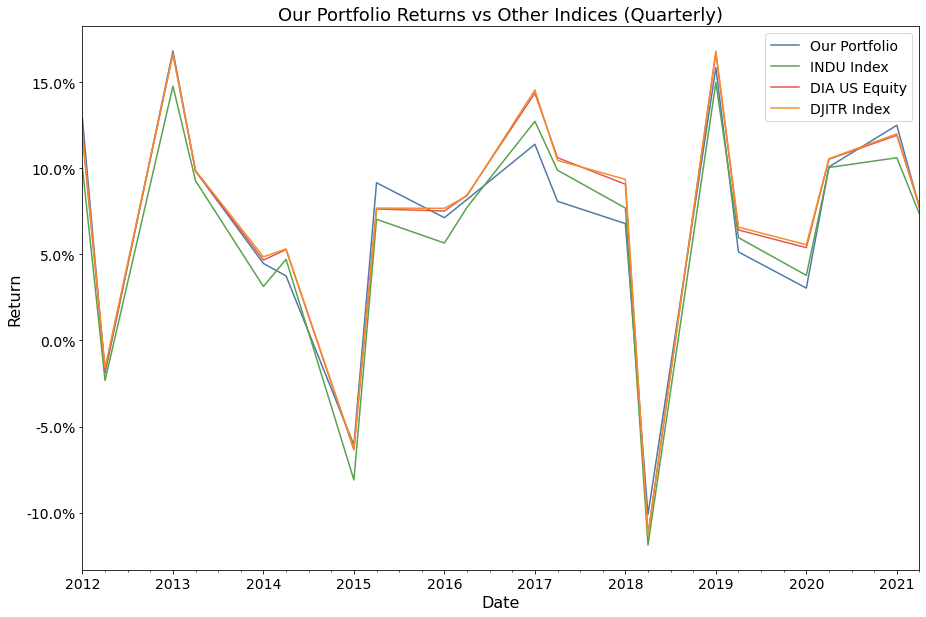

In [8]:
final_df['quarter'] = final_df['Date'].dt.quarter
final_df['year'] = final_df['Date'].dt.year
final_df['year_quarter'] = final_df['year'].astype(str) + '_' + final_df['quarter'].astype(int).astype(str)
final_df['year_quarter'] = pd.to_datetime(final_df['year_quarter'], format="%Y_%m")
final_df['year_quarter'] = final_df['year_quarter'].dt.to_period('Q')

final_df.groupby('year_quarter')['weighted_return'].sum().plot(kind='line', figsize=(15,10), title='Our Portfolio Returns vs Other Indices (Quarterly)', label='Our Portfolio', color='#4E79A7')
final_df.groupby('year_quarter')['INDU Index'].sum().plot(kind='line', figsize=(15,10), label='INDU Index', color='#59A14F')
final_df.groupby('year_quarter')['DIA US Equity'].sum().plot(kind='line', figsize=(15,10), label='DIA US Equity', color='#E15759')
final_df.groupby('year_quarter')['DJITR Index'].sum().plot(kind='line', figsize=(15,10), label='DJITR Index', color='#F28E2B')

# format the chart
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=14)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Return', fontsize=16)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.title('Our Portfolio Returns vs Other Indices (Quarterly)', fontsize=18)
plt.legend(fontsize=14)
plt.show()

### Graph our portfolio cumulative returns and comparison indices cumulative returns by quarter

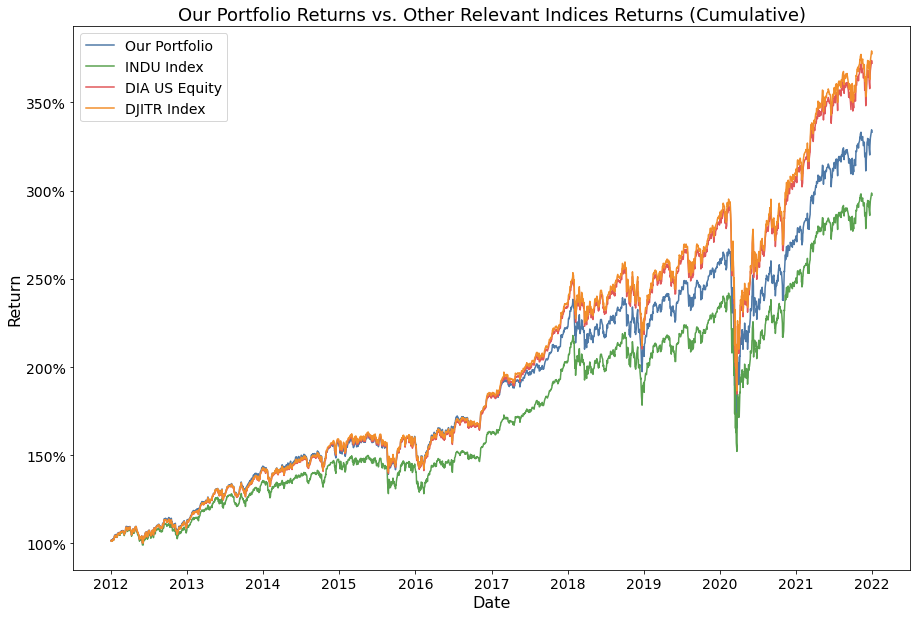

In [9]:
cumulative_return = (final_df['weighted_return'] + 1).cumprod()
cumulative_return_indu = (final_df['INDU Index'] + 1).cumprod()
cumulative_return_dia = (final_df['DIA US Equity'] + 1).cumprod()
cumulative_return_djit = (final_df['DJITR Index'] + 1).cumprod()

plt.figure(figsize=(15,10))
plt.plot(final_df['Date'], cumulative_return, label='Our Portfolio', color='#4E79A7')
plt.plot(final_df['Date'], cumulative_return_indu, label='INDU Index', color='#59A14F')
plt.plot(final_df['Date'], cumulative_return_dia, label='DIA US Equity', color='#E15759')
plt.plot(final_df['Date'], cumulative_return_djit, label='DJITR Index', color='#F28E2B')

# format the chart
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=14)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Return', fontsize=16)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.title('Our Portfolio Returns vs. Other Relevant Indices Returns (Cumulative)', fontsize=18)
plt.legend(fontsize=14)
plt.show()



### Graph the difference between our portfolio returns and the comparison indices returns

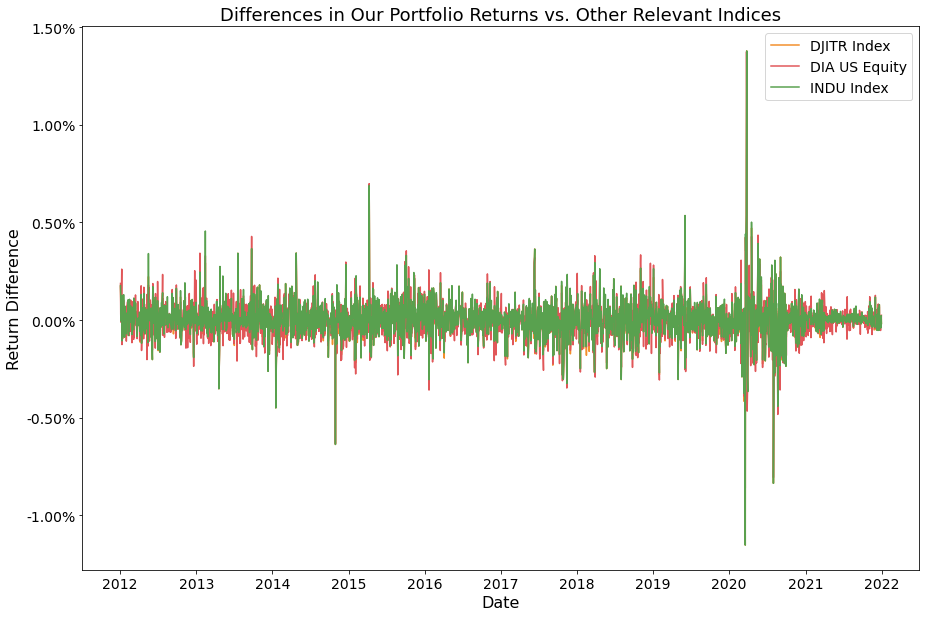

In [10]:
plt.figure(figsize=(15,10))
plt.plot(final_df['Date'], final_df['weighted_return'] - final_df['DJITR Index'], label='DJITR Index', color='#F28E2B')
plt.plot(final_df['Date'], final_df['weighted_return'] - final_df['DIA US Equity'], label='DIA US Equity', color='#E15759')
plt.plot(final_df['Date'], final_df['weighted_return'] - final_df['INDU Index'], label='INDU Index', color='#59A14F')

# format the chart
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=14)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Return Difference', fontsize=16)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.title('Differences in Our Portfolio Returns vs. Other Relevant Indices', fontsize=18)
plt.legend(fontsize=14)
plt.show()


### Regression Comparison of Portfolio Returns and Comparison Indices Returns

#### INDU Index:

In [11]:
indu_mod = sm.OLS(np.array(final_df['weighted_return'],dtype=float), np.array(final_df['INDU Index'],dtype=float))
indu_mod_fitted = indu_mod.fit()
indu_mod_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                          2.941e+05
Date:                Mon, 03 Oct 2022   Prob (F-statistic):                        0.00
Time:                        23:26:21   Log-Likelihood:                          13866.
No. Observations:                2517   AIC:                                 -2.773e+04
Df Residuals:                    2516   BIC:                                 -2.773e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0073      0.002    542.276      0.000       1.004       1.011
==============================================================================
Omnibus:                      925.733   Durbin-Watson:                   1.700
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            95316.708
Skew:                           0.754   Prob(JB):                         0.00
Kurtosis:                      33.110   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### DIA US Equity:

In [12]:
djia_mod = sm.OLS(np.array(final_df['weighted_return'],dtype=float), np.array(final_df['DIA US Equity'],dtype=float))
djia_mod_fitted = djia_mod.fit()
djia_mod_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                          2.625e+05
Date:                Mon, 03 Oct 2022   Prob (F-statistic):                        0.00
Time:                        23:26:21   Log-Likelihood:                          13725.
No. Observations:                2517   AIC:                                 -2.745e+04
Df Residuals:                    2516   BIC:                                 -2.744e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0123      0.002    512.361      0.000       1.008       1.016
==============================================================================
Omnibus:                      897.241   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40046.280
Skew:                           0.946   Prob(JB):                         0.00
Kurtosis:                      22.449   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### DJITR Index:

In [13]:
djitr_mod = sm.OLS(np.array(final_df['weighted_return'],dtype=float), np.array(final_df['DJITR Index'],dtype=float))
djitr_mod_fitted = djitr_mod.fit()
djitr_mod_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                          3.081e+05
Date:                Mon, 03 Oct 2022   Prob (F-statistic):                        0.00
Time:                        23:26:21   Log-Likelihood:                          13925.
No. Observations:                2517   AIC:                                 -2.785e+04
Df Residuals:                    2516   BIC:                                 -2.784e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0071      0.002    555.064      0.000       1.004       1.011
==============================================================================
Omnibus:                      991.522   Durbin-Watson:                   1.675
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           117536.031
Skew:                           0.847   Prob(JB):                         0.00
Kurtosis:                      36.434   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Final Output Dataframes

In [14]:
# merge final_df with the stock data to get returns of each stock per day
display_merge_df = final_df.merge(dow_returns, left_on = 'Date', right_on = 'datadate', how = 'left')

# drop everything but stock_return, stock_weight, Date, comn_x
display_merge_df = display_merge_df[['stock_return', 'stock_weight', 'Date', 'conm_x']]

# sort by Date and conm_x
display_merge_df = display_merge_df.sort_values(by=['Date', 'conm_x'])

# change format for output
display_merge_df.rename(columns={'stock_return':'Security Return', 'stock_weight':'Security Weight', 'conm_x':'Company Name'}, inplace=True)
display_merge_df = display_merge_df.set_index('Date')
display_merge_df['Security Return'] = display_merge_df['Security Return'].apply(lambda x: '{:.3%}'.format(x) if not np.isnan(x) else x)

# title for table
print()
print('\033[1m' + '\033[91m' + '\033[4m' + 'Daily Security Weights and Security Returns' + '\033[0m')

display_merge_df.head(10)


Daily Security Weights and Security Returns


,Security Return,Security Weight,Company Name
Date,,,
2012-01-03,2.153%,0.047712,3M CO
2012-01-03,6.705%,0.015826,ALCOA INC
2012-01-03,2.586%,0.027654,AMERICAN EXPRESS CO
2012-01-03,0.463%,0.017361,AT&T INC
2012-01-03,4.317%,0.003315,BANK OF AMERICA CORP
2012-01-03,1.186%,0.042415,BOEING CO
2012-01-03,3.731%,0.053707,CATERPILLAR INC
2012-01-03,3.731%,0.063073,CHEVRON CORP
2012-01-03,3.374%,0.010647,CISCO SYSTEMS INC


In [15]:
final_df.head()

display_index_totals_df = final_df.copy()

# maniuplate the data for output
display_index_totals_df.rename(columns={'adj_close':'Value of Portfolio'}, inplace=True)
display_index_totals_df.rename(columns={'weighted_return':'Return of Portfolio'}, inplace=True)
display_index_totals_df.set_index('Date', inplace=True)
display_index_totals_df.drop(['quarter', 'year', 'year_quarter', 'INDU Index', 'DIA US Equity', 'DJITR Index'], axis=1, inplace=True)

# format the values
display_index_totals_df['Value of Portfolio'] = display_index_totals_df['Value of Portfolio'].map('${:,.2f}'.format)
display_index_totals_df['Return of Portfolio'] = display_index_totals_df['Return of Portfolio'].map('{:,.3%}'.format)

# title for table
print()
print('\033[1m' + '\033[91m' + '\033[4m' + 'Daily Value of Portfolio and Return of Portfolio' + '\033[0m')

display_index_totals_df.head(10)


Daily Value of Portfolio and Return of Portfolio


,Value of Portfolio,Return of Portfolio
Date,,
2012-01-03,"$1,749.87",1.648%
2012-01-04,"$1,754.81",0.307%
2012-01-05,"$1,754.37",-0.027%
2012-01-06,"$1,747.43",-0.345%
2012-01-09,"$1,753.83",0.366%
2012-01-10,"$1,761.91",0.457%
2012-01-11,"$1,762.32",0.022%
2012-01-12,"$1,766.38",0.212%
2012-01-13,"$1,759.30",-0.394%


### Metrics and Justification
<ol type='I'>
<li>Mean
<ol type='i'>
<li>
Comparison of the mean return of our portfolio against that of the relevant comparison indices will be indicative of the performance of our tracking portfolio. Portfolio mean would be easily understood by a client and could quickly convey our tracking accuracy.
</li>
</ol>
</li>
<li>Standard Deviation
<ol type='i'>
<li>
The standard deviation of our portfolio returns compared to those of the comparison indices is a good measure of how well our portfolio tracks the Dow. Like the measure of the mean return, the standard deviation is easily understood by a client and could quickly convey our tracking accuracy.
</li>
</ol>
</li>
<li>Tracking Error
<ol type='i'>
<li>
The tracking error is another good metric that communicates tracking performance. It is a measure of the standard deviation of the pairwise differences between the returns of our portfolio and the comparison indices. The lower the tracking error, the better our portfolio tracks the Dow. 
</li>
</ol>
</li>
<li>R-Squared
<ol type='i'>
<li>
The R-Squared is a measure of how well our portfolio tracks the Dow. It is a measure of the proportion of the variance in the Dow (or relevant comparison index) that is explained by the returns of our portfolio. The higher the R-Squared, the better our portfolio tracks the Dow and an R-Squared of 1 would indicate perfect tracking.
</li>
</ol>
</li>
<li>Standard Error of the Regression (SER)
<ol type='i'>
<li>
The Standard Error of the Regression (SER) is a measure of the average distance between the regression line and the data points. The lower the SER, the better our portfolio tracks the Dow. This is a good metric because it conveys in percentage terms how "off" our predictions are (the regression line) on average from the actual returns of the Dow. 
</li>
</ol>
</li>
</ol>

In [16]:
# Mean
port_mean = final_df['weighted_return'].mean()
djitr_mean = final_df['DJITR Index'].mean()
dia_mean = final_df['DIA US Equity'].mean()
indu_mean = final_df['INDU Index'].mean()

# Standard Deviation
port_std = final_df['weighted_return'].std()
djitr_std = final_df['DJITR Index'].std()
dia_std = final_df['DIA US Equity'].std()
indu_std = final_df['INDU Index'].std()

# Tracking Error
djitr_tracking_error = final_df['weighted_return'] - final_df['DJITR Index']
djitr_tracking_error = djitr_tracking_error.std()

dia_tracking_error = final_df['weighted_return'] - final_df['DIA US Equity']
dia_tracking_error = dia_tracking_error.std()

indu_tracking_error = final_df['weighted_return'] - final_df['INDU Index']
indu_tracking_error = indu_tracking_error.std()

# R-Squared
djitr_r_squared = djitr_mod_fitted.rsquared
dia_r_squared = djia_mod_fitted.rsquared
indu_r_squared = indu_mod_fitted.rsquared

# Standard Error of the Regression
djitr_se = djitr_mod_fitted.scale**0.5
dia_se = djia_mod_fitted.scale**0.5
indu_se = indu_mod_fitted.scale**0.5


summary_df = pd.DataFrame({'Mean': [port_mean, djitr_mean, dia_mean, indu_mean],
                            'Standard Deviation': [port_std, djitr_std, dia_std, indu_std],
                            'Tracking Error': [0, djitr_tracking_error, dia_tracking_error, indu_tracking_error],
                            'R Squared': [0, djitr_r_squared, dia_r_squared, indu_r_squared],
                            'Standard Error of Regression': [0, djitr_se, dia_se, indu_se]},
                            index=['Portfolio', 'DJITR Index', 'DIA US Equity', 'INDU Index'])

# format the summary_df
summary_df['Mean'] = summary_df['Mean'].map('{:,.5%}'.format)
summary_df['Standard Deviation'] = summary_df['Standard Deviation'].map('{:,.5%}'.format)
summary_df['Tracking Error'] = summary_df['Tracking Error'].map('{:,.5%}'.format)
summary_df['R Squared'] = summary_df['R Squared'].map('{:,.5}'.format)
summary_df['Standard Error of Regression'] = summary_df['Standard Error of Regression'].map('{:,.5%}'.format)

# replace zeros with blanks
summary_df = summary_df.replace('0.00000%', '')
summary_df = summary_df.replace('0.0', '')

# title for table
print()
print('\033[1m' + '\033[91m' + '\033[4m' + 'Summary Statistics' + '\033[0m')

summary_df


Summary Statistics


,Mean,Standard Deviation,Tracking Error,R Squared,Standard Error of Regression
Portfolio,0.05350%,1.06275%,,,
DJITR Index,0.05836%,1.05072%,0.09594%,0.9919,0.09577%
DIA US Equity,0.05772%,1.04454%,0.10439%,0.99051,0.10368%
INDU Index,0.04886%,1.05079%,0.09820%,0.99152,0.09801%
